# Linear regression: prediction and diagnostics
Let's refit our linear regression model to our data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
states_data = pd.read_csv("data/states_data.csv")


def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t[x])*standard_units(t[y]))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t[label_y])/np.std(t[label_x])

def intercept(t, label_x, label_y):
    return np.mean(t[label_y])-\
    slope(t, label_x, label_y)*np.mean(t[label_x])


model_slope = slope(states_data, 'cig_tax12', 'smokers12')
model_intercept = intercept(states_data, 'cig_tax12', 'smokers12')

print("intercept...")
print(model_intercept) 
print("\n")
print("model slope...")
print(model_slope)

intercept...
23.388876340779785


model slope...
-1.5908929289147922


## Simple Prediction
Now that we have the slope and the intercept, we can provide simple predictions.  In particular, if you give me an $X$ value, I can tell you what the linear regression predicts will be $Y$ value for that observation.  The formula, which is the formula of the line on our graph, is:

$$
\text{predicted $Y$}= 23.39 + (-1.59)x
$$

So, if the tax per pack is $\$5$, the predicted percentage of smokers is

$$
\text{predicted $Y$}= 23.39 + (-1.59)5
$$

or 15.44\%.  If the tax becomes a subsidy (i.e. it reduces the cost of a pack) of $\$10$, the predicted percentage of smokers is

$$
\text{predicted $Y$}= 23.39 + (-1.59)-10
$$

or 39.29\%.  Notice that nothing in the model forces the predictions to be "sensible" (i.e. forces the percentage to be between 0 and 100).  For example, if we raise the tax to \$17 per packet, our prediction is that the percentage of smokers is 

$$
\text{predicted $Y$}= 23.39 + (-1.59)17
$$

which implies the percentage of the state population that smokes is $-3.64$\%.  And that's not a possible value.  So some care is required when we *extrapolate* (go far beyond) the current data (in terms of actual $x$ and $y$ values).

Just for completeness, here is a simple function that predicts a $Y$ value for any $X$ value of interest:

In [2]:
def fit(dframe, x, y):
    """Return the value of the regression line at each x value."""
    beta = slope(dframe, x, y)
    constant = intercept(dframe, x, y)
    return (beta*dframe[x]) + constant

Here we apply the function to our entire dataset just to get the prediction line  (the linear regression line) for every observation:

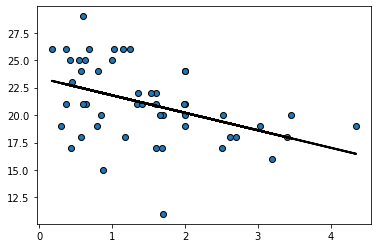

In [3]:
regression_prediction = fit(states_data, 'cig_tax12','smokers12')

plt.scatter(states_data['cig_tax12'], states_data['smokers12'], 
            edgecolors="black")

plt.plot(states_data['cig_tax12'], regression_prediction, 
         color="black", linewidth=2)
plt.show()

## Residuals
For every *actual* observation in our data, we have a *prediction* for it from the regression model. This is what the line tells us, and you can think of it as what we would expect the state's $Y$ value to be if our linear model was completely accurate. Take a look at this snippet of our earlier graph, which shows the far right portion of the regression line.

:::{figure-md} smoke_snippet
<img src="figures/smoke_snippet.png" alt="smoke_snippet" class="bg-white mb-1" width="300">

The far right portion of our earlier regression line
:::

We can see that the *actual* observation for New York (NY) is *above* the regression line.  Meanwhile, the *actual* observation for Hawaii (HI) is *below* the regression line.  This tells us that, in some sense, New York's tax ($x$-value) is consistent with a *lower* smoking percentage than we actually see in that state.  Meanwhile, Hawaii's tax rate is consistent with a *higher* smoking percentage than we actually see in that state.

In fact, we can be more precise.  The *actual* value for New York's $Y$ is 19\% (smoking).  But the *predicted* value for New York, sometimes written $\hat{Y}$ and said "Y-hat" is 16.46. We can write a function to provide this predicted value for any observation we want: 

In [4]:
def make_reg_prediction(state="NY"):
    states_data['clean_stateid'] = states_data['stateid'].str.strip()
    sd = states_data[states_data['clean_stateid']==state]
    pred = model_slope*sd['cig_tax12'] + model_intercept
    predf = float(pred)
    return(predf)

For New York, this is:

In [5]:
make_reg_prediction(state="NY")

16.46849210000044

This brings us to an important term. We can define a **residual** as being the difference between $Y$ and $\hat{Y}$. In particular, the residual for a given observation is 

> $Y-\hat{Y}$ for that observation

For New York, the residual is thus: $19-16.46$, or $2.54$.

We say this is a *positive* residual because it is greater than zero. Meanwhile, Hawaii had a *negative* residual, because this number ($Y-\hat{Y}$ for Hawaii) was *less* than zero.  

We will use the *sum* of the *squared* residuals momentarily, but for now notice that there are some important facts about residuals themselves: 
1. residuals in a regression *sum to zero*.  The intuitive reason is that, if they didn't---that is, if the positive ones weren't completely offset by the negative ones---we could alter $a$ and $b$ little to get the sum to zero.  And that would suggest a better fitting line. Similarly, the residuals are *on average* zero.
2. the residuals are *uncorrelated* with our predictor variable (our $X$). This follows from fact 1, but we won't explore exactly why in this course.
3. the residuals are *informative about model fit*.  That is, they can tell us how well our straight line describes the data.  We will return to this idea below.

## Residuals and the best fit line
In what sense does is our linear regression line the line that fits the data "best"?  Well, it is the line that minimizes the all the residuals. Specifically, it is the **ordinary least squares** line that

> minimizes the sum of the squared residuals

For obvious reasons, the ordinary least squares line, and indeed the technique in general, is sometimes referred to by its initials, **OLS**.

### Best fit line
We are fitting via OLS, which *minimizes the sum of squared residuals*. Literally, it is finding a value of $a$ and $b$ that will minimize (make as small as possible) this sum:

$$
\sum (y_i - (a+bx_i))^2
$$

This is another way of describing the *residual*, above.  For a given row of the data, the $y_i$ is the actual value of the dependent variable.  Meanwhile, $a+bx_i$ is our linear *model* of that dependent variable.  That is, it is the point on the regression line---our prediction---for that observation.  But then $y_i- (a+bx_i)$ is just another way of writing $y_i-\hat{y_i}$

The idea is that the sum, $\sum$, is happening over every row $i$ in the data.  For each observation we have a value of the dependent variable $y_i$ and the independent variable $x_i$.  So, for the first observation the calculation (the square of the residual) is 

$$
(y_1 - (a+bx_1))^2
$$

this is added to the second squared residual

$$
(y_2 - (a+bx_2))^2
$$

And so on, down the data. Intuitively, it is as if we are trying out different values of $a$ and $b$ until we find the one that minimizes that sum.  Indeed, a linear model that fits perfectly would have $y_i$ *equal to* $a+bx_i$ for all observations and thus the sum would be *zero*.  

Now, in fact, we don't literally try each possible value of $a$ and $b$---there is a matrix algebra solution that finds the minimum very quickly.  Notice that this solution will be *unique*: there is only *one* best fit line possible for a given linear regression problem.  

## Residuals and diagnostics

As the logic above suggests, it is straightforward to calculate the residual for any given observation. Ideally, we would like these residuals to be approximately the same size, no matter what the particular value of $X$.  This is equivalent to saying we want the spread of the residuals to look similar throughout the data.  We call that spread of the residuals the **error variance**.

Another way to put this is that we don't want the line to fit systematically better for some values of $X$ and worse for others.  If it does, i.e. if the nature of the residuals changes as $X$ increases or decreases, we have evidence of **non-constant error variance**, which sometimes goes by the name **heteroscedasticity**.

The *consequences* of heteroscedasticity are twofold from our perspective: 
- first, it can generate problems with interpreting coefficients.  In particular, it can lead to make type-I or type-II errors when declaring that a specific coefficient (so the $b$ for a specific variable) is "statistically significant" or not
- second, it is emblematic of a *specification error*.  That is, non-constant error variance potentially tells that a *linear* regression is not appropriate, and perhaps we should have allowed for  a *non-linear* model (line) through our data instead.

To get a sense of the diagnosis procedure, let's start by writing a simple function to calculate the residuals for a given regression of $y$ on $x$ (this uses the `fit()` function above):

In [6]:
def residual(dframe, x, y):
    return dframe[y] - fit(dframe, x, y)

To get a sense of how *constant* error variance looks, we can generate some (fake) data which we know does not suffer from heteroscedasticity. We won't belabor the details, but we make our $x$ variable to be 200 random draws from a normal distribution, and our $y$ variable to be 200 random draws from a different normal distribution.  Then we will put these in a data frame and call the `residual` function from the regression of the (fake) $y$ on the (fake) $x$.

In [7]:
np.random.seed(5)
fake_x = np.random.normal(3,1, 200)
fake_y = np.random.normal(2,2, 200)
fake_data = pd.DataFrame().assign(x=fake_x, y=fake_y)
perfect_residuals  = residual(fake_data, 'x', 'y')

Now, we just want to plot these (fake) residuals in terms of the value of the predictor variable on the $x$-axis, versus the value of the residuals themselves on the $y$-axis.  They should a mean of zero, but importantly, they should also be spread above and below the line to roughly the same degree *whatever* the value of $x$.

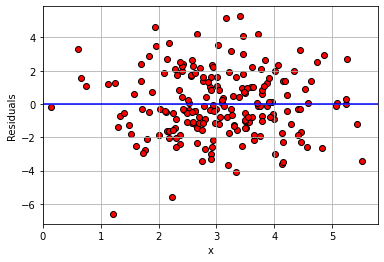

In [8]:
plt.scatter(fake_data['x'], perfect_residuals, 
            color="red", edgecolors="black")
plt.ylabel("Residuals")
plt.xlabel("x")
plt.xlim(0, None)
plt.axhline(0, color="blue")
plt.grid()
plt.show()

That is approximately what we see: as we move from low values of $x$ (so, zero or one) to high values of $x$ (so, four or five), the variance of the red dots around the blue zero line doesn't change very much.  This is constant error variance.

What about for our regression above?  

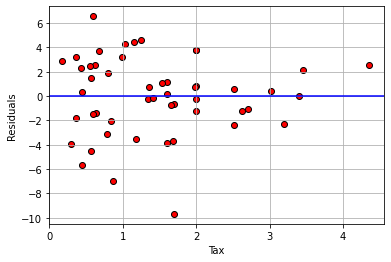

In [14]:
model_residuals = residual(states_data, "cig_tax12", "smokers12")

plt.scatter(states_data['cig_tax12'], 
            model_residuals, color="red", edgecolors="black")
plt.ylabel("Residuals")
plt.xlabel("Tax")
plt.xlim(0, None)
plt.axhline(0, color="blue")
plt.grid()
plt.show()

Here, the error variance for low values of the tax variable are more evenly spread than for high values.  And, for high tax states, the residuals are smaller.  This suggests our model does a better job of fitting the observations for high-tax states.  In general then, it seems we may have *some* non-constant error variance.

For an even sharper example, consider a regression of the percentage of a state's population that is pro-Choice (`prochoice`) on its proportion of Hispanic residents (`hispanic08`). 

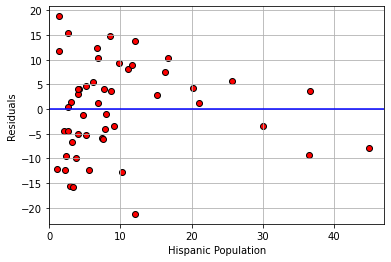

In [10]:
model2_residuals = residual(states_data, 'hispanic08', 'prochoice')

plt.scatter(states_data['hispanic08'], 
            model2_residuals, color="red", edgecolors="black")
plt.ylabel("Residuals")
plt.xlabel("Hispanic Population")
plt.xlim(0, None)
plt.axhline(0, color="blue")
plt.grid()
plt.show()

We see something quite different here.  For low Hispanic population values, the error variance looks somewhat constant.  But for mid-levels, the residuals are mostly *above* the line (we underpredict for these states).  For relatively large values of Hispanic population, the residuals are mostly below the line (we overpredict for these states).  This suggests that $y$ might not be linear in $x$ and that a different model is called for.

Indeed, looking at the regression line for this example suggests it should perhaps be more of a curve: 

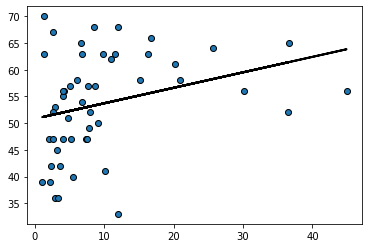

In [15]:
regression_prediction2 = fit(states_data, 'hispanic08','prochoice')

plt.scatter(states_data['hispanic08'], states_data['prochoice'], 
            edgecolors="black")

plt.plot(states_data['hispanic08'], regression_prediction2, 
         color="black", linewidth=2)
plt.show()

## Model fit
How well does our regression fit our data?  One common way to think about it is in terms of the amount of variation in $y$ (the thing we are trying to predict) that is explained by our linear model that uses $x$.  When this number is *large*, we are saying that, overall, we can predict $y$ very well using our model; when it is *small*, we are saying that, overall, we cannot predict $y$ very well using our model.  

The particular measure we will use is called **R-squared** or **R-square** or  $\mathbf{R^2}$.  It is 

> the proportion of the variance in the outcome ($y$) that our linear regression explains; and it is the square of the correlation between $x$ and $y$.

Perhaps unsurprisingly, when $x$ and $y$ are highly correlated ($r_{XY}$ is large), we expect to do a better job of predicting $y$ from $x$ and the model.

As with the slope and the intercept, there are many ways to calculate $R^2$.  We will use this method:

$$
R^2 = \frac{\mbox{variance of fitted values}}{\mbox{variance of } y}
$$

From the formula, we can see that when the variance of the fitted values is the same as the variance of $y$, then $R^2$ will be one, which is the highest it can be.  By contrast, if the fitted values don't have any variance -- meaning we are predicting the same value of $y$ for every $x$ -- then $R^2$ is zero, which is the worst-fitting model possible.

The fact that $R^2$ is just the correlation squared makes it easy to write a function for: 

In [16]:
def r2(t, x, y):
    return correlation(t, x, y)**2

Applied to our model, we see that proportion of variance explained is about 0.19 (19\% of the variance in $Y$ is explained by our model).

In [17]:
r2(states_data, "cig_tax12", "smokers12")

0.18619559936896055